### Imports

In [14]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from MALDI_class import MALDI, rawMALDI, binnedMALDI, selectedMALDI
from metaspace_class import metaspace
import os
import nibabel as nib


### Set file parameters

In [4]:
raw_data_folder = '/data/datadata/40_MALDI/MALDI/'
#'/data/pt_02040/MyelinQuantificationProject/raw_data/MALDI/'
background_mask_folder = '/data/datadata/40_MALDI/MALDI/coregistration/'
#'/data/pt_02040/MyelinQuantificationProject/coregistration/'

results_folder = 'expdata/final/'
#'/data/pt_02040/MyelinQuantificationProject/results_final/

samples = np.loadtxt(results_folder + 'samples.csv', dtype = str)#pattern: 'brain{sample}re_{section}_{ROI}
paths = np.array([raw_data_folder + samples[i].split('_')[0] + '-' + samples[i].split('_')[1] + '/' + samples[i].split('_')[2] + '/RAW-Data/' + samples[i].split('_')[0] + '-' + samples[i].split('_')[1] + '_' + samples[i].split('_')[2] + '_pos' + '.imzML' for i in range(len(samples))])

#REMOVE FROM HERE
for sample_index in range(len(samples)):
    if not os.path.isfile(paths[sample_index]):
        paths[sample_index] = paths[sample_index].split('.')[0] + '_validated.' + paths[sample_index].split('.')[1]
    if not os.path.isfile(paths[sample_index].split('.')[0] + '.ibd'):
        paths[sample_index] = None
        samples[sample_index] = None
paths = paths[samples != 'None']
samples = samples[samples != 'None']
samples = np.array([samples[0]])
paths = np.array([paths[0]])
#REMOVE UNTIL HERE
print(samples)

['brain201re_49_V1']


### Set MALDI data parameters

In [5]:
MALDI_parameters = {
	'resolution' : 1e-5,		#ppm
	'accuracy' : 2.5e-6,
	'normalize' : 'tic',
    'n_processes' : 1
}
MALDI_results = {
    'selected_mzs' : [],
    'shape' : [],
    'TIC' : [],
    'mean_spectrum' : [],
    'center_of_mass' : [],
    'mzmaps' : [],
    'background_data' : [],
    'tissue_data' : []
}
    

### Set METASPACE parameters

In [6]:
### Database parameters ###
name = results_folder + 'metaspacefiltering'

metaspaceparams = {
	'databases' : ['HMDB', 'SwissLipids', 'LipidMaps'],
	'max_fdr' : .05,
    'api_key' : 'vxBtcaq839qX'
	}

### Matrix reference measurement parameters ###
matrixproject = 'b9195154-ba0d-11eb-96db-bbe19b6ae1a2'
matrixdataset = ['2021-05-21_10h24m13s', '2021-06-09_13h10m10s', '2021-07-02_15h25m26s']

### SAMPLE IDENTIFIERS FOR OLD, GREY NEW AND BRIGHT NEW DATA ###
project_id = '7b876960-ecbc-11ec-89bf-5b32557b3a87'
dataset_ids = ['2020-11-16_10h33m20s', '2020-11-16_11h12m42s', '2020-11-16_11h13m38s', '2020-11-16_11h15m09s', '2020-11-16_11h18m12s', '2020-11-16_11h21m21s', '2020-11-16_11h23m40s', '2022-04-22_13h50m55s', '2022-04-22_13h53m22s', '2022-04-22_13h43m51s', '2022-04-22_13h58m27s', '2022-04-22_13h57m25s', '2022-04-22_13h59m24s', '2022-04-22_14h00m05s']


### Get matrix annotations

In [7]:
matrix = metaspace(matrixdataset, databases = metaspaceparams['databases'], proj_id = matrixproject, api_key = metaspaceparams['api_key'])
matrix.get_datasets(drop_duplicates = False, sort_by = ['mz'])
matrixmzs = np.unique(matrix.data.mz.values)
#manually selected matrix ions
matrixions = ['C24H49NO3+H+', 'C27H46O4+Na+', 'C47H79NO8+Na+', 'C42H82NO11P+H+', 'C49H83NO8+Na+', 'C19H14O9+Na+', 'C10H15N5O9P2+H+', 'C24H40O4+Na+', 'C24H50NO7P+K+', 'C30H58NO10P+H+', 'C38H77NO4+Na+', 'C31H60NO10P+H+', 'C42H81NO3+H+', 'C32H62NO10P+H+', 'C40H81NO4+Na+', 'C41H83NO5+Na+', 'C37H71O8P+K+', 'C40H66O12+H+', 'C41H77O8P+K+', 'C43H76NO7P+Na+', 'C45H78NO7P+Na+', 'C42H81O10P+Na+', 'C45H80NO7P+Na+', 'C47H82NO7P+Na+', 'C46H90NO10P+H+', 'C47H93N2O6P+K+', 'C47H92NO8P+Na+', 'C46H90NO11P+H+', 'C48H94NO7P+K+', 'C20H36O2+H+', 'C20H43NO+H+', 'C21H36O5+Na+', 'C25H46O2+Na+', 'C23H47NO4+H+', 'C22H28O6+Na+', 'C30H50+Na+', 'C36H75N+H+', 'C26H54NO7P+H+', 'C40H81NO3+Na+', 'C42H81NO3+H+', 'C33H64NO9P+H+', 'C33H64NO10P+H+', 'C35H68NO9P+H+', 'C33H64NO10P+Na+', 'C35H68NO10P+Na+', 'C41H72O10+H+', 'C41H83N2O6P+H+', 'C23H34O5+H+', 'C27H44O2+H+', 'C26H38O4+H+', 'C37H70O12S+H+', 'C40H80NO8P+K+', 'C42H82NO8P+K+', 'C42H84NO8P+K+', 'C44H86NO8P+K+', 'C49H90NO8P+H+', 'C46H92NO11P+H+', 'C39H73O8P+K+', 'C45H74NO7P+H+']

### Get tissue annotations

In [8]:
mydataset = metaspace(dataset_ids, databases = metaspaceparams['databases'], proj_id = project_id, api_key = metaspaceparams['api_key'])

### Set filter parameters

In [9]:
filterparams = {
	'drop_duplicates' : False,
	'msm' : [.8],		#values for msm score threshold to evaluate
	'appearances' : [0],		#number of datasets a peak must appear in
	'force_dataset' : [None],		#datasets a peak must appear in at least on of
	'matrixmzs' : matrixmzs,		#List of matrix mz values to remove from the peaklist
	'matrixions' : matrixions,		#List of matrix ion names to remove from the peaklist
	'removerange' : 10e-6,
	'mzrange' : [400,1000]
}

### Filter annotations according to filterparameters and store the results in a csv table and overview figure

In [10]:

for msm in filterparams['msm']:
	for appearances in filterparams['appearances']:
		for force_dataset in filterparams['force_dataset']:
			print(appearances, msm, force_dataset)

			### GET DATASETS ###
			mydataset.get_datasets(drop_duplicates = filterparams['drop_duplicates'], sort_by = ['mz'])
			mydataset.data.sort_values(['mz'], inplace = True)

			### FILTER BY MSM ###
			mydataset.filter_by(parameters = ['msm'], values = [str(msm)], operators = ['>'])
			name += '_msm>' + str(msm)
			print('filter by msm>' + str(msm) + ' reduced to ' + str(np.unique(mydataset.data.mz.values).shape) + ' entries')
			#mydataset.data.to_csv(name + '.csv')

			### FILTER BY APPEARANCE ###
			val, ind, counts = np.unique(mydataset.data.mz.values, return_index = True, return_counts = True)
			mydataset.data = mydataset.data[mydataset.data.mz.isin(val[counts>appearances])]
			name += '_appearance=' + str(appearances)
			print('filter by appearance=' + str(appearances) + ' reduced to ' + str(np.unique(mydataset.data.mz.values).shape) + ' entries')
			#mydataset.data.to_csv(name + '.csv')

			### FILTER BY SINGLE DATASET ###
			if force_dataset is not None:
				mydataset.filter_by(parameters = ['dataset'], values = [str(force_dataset)], operators = ['=='])
				name += '_force_dataset=' + str(force_dataset)
				print('filter by force_dataset=' + str(force_dataset) + ' reduced to ' + str(np.unique(mydataset.data.mz.values).shape) + ' entries')

			### DROP DUPLICATES ###
			mydataset.data.drop_duplicates(subset = ['ionFormula', 'ion'], inplace = True)		#remove resulting duplicates
			print('drop_duplicates' + ' reduced to ' + str(np.unique(mydataset.data.mz.values).shape) + ' entries')

			### FILTER BY MATRIX MEASUREMENT ###
			if filterparams['matrixmzs'] is not None:
				mydataset.data = mydataset.data[~mydataset.data['mz'].isin(filterparams['matrixmzs'])]
				print('filter by matrixmzs' + ' reduced to ' + str(np.unique(mydataset.data.mz.values).shape) + ' entries')
				mydataset.data = mydataset.data[~mydataset.data['ion'].isin(filterparams['matrixions'])]
				name += '_matrixmzs'
				print('filter by matrixmzs and matrixions' + ' reduced to ' + str(np.unique(mydataset.data.mz.values).shape) + ' entries')

			### remove in 10ppm range ###
			if filterparams['removerange'] is not None:
				mydataset.filter_neighboring_mzs(rrange = filterparams['removerange'])
				name += '_removed' + str(filterparams['removerange'])
				print('filter by removerrange' + ' reduced to ' + str(np.unique(mydataset.data.mz.values).shape) + ' entries')

			### FILTER BY mzrange ###
			mydataset.filter_by(parameters = ['mz'], values = [str(filterparams['mzrange'][0])], operators = ['>'])
			mydataset.filter_by(parameters = ['mz'], values = [str(filterparams['mzrange'][1])], operators = ['<'])
			name += '_mzrange>' + str(filterparams['mzrange'])
			print('filter by msm>' + str(filterparams['mzrange']) + ' reduced to ' + str(np.unique(mydataset.data.mz.values).shape) + ' entries')
			#mydataset.data.to_csv(name + '.csv')

			### STORE DATA ###
			mydataset.data.insert(0, 'index', np.arange(1,mydataset.data.shape[0]+1))
			mydataset.data.to_csv(name + '.csv', columns = ['index', 'ionFormula', 'ion', 'mz', 'msm', 'rhoSpatial', 'rhoSpectral', 'moc', 'fdr', 'moleculeNames', 'moleculeGroups'])
			MALDI_results['selected_mzs'] = np.unique(mydataset.data.mz.values)
            n_peaks = len(MALDI_results['selected_mzs'])

0 0.8 None
filter by msm>0.8 reduced to (249,) entries
filter by appearance=0 reduced to (249,) entries
drop_duplicates reduced to (177,) entries
filter by matrixmzs reduced to (163,) entries
filter by matrixmzs and matrixions reduced to (114,) entries
filter by removerrange reduced to (80,) entries
filter by msm>[400, 1000] reduced to (76,) entries


### Iterate through samples and process MALDI Data

In [ ]:
for sample_index in range(len(samples)):
    ### LOAD DATA ###
    if not os.path.isfile(paths[sample_index]):
        paths[sample_index] = paths[sample_index].split('.')[0] + '_validated.' + paths[sample_index].split('.')[1]
    M = MALDI(paths[sample_index], resolution = MALDI_parameters['resolution'], n_processes = MALDI_parameters['n_processes'])
    print('number of pixels', len(M.indices))
    print('image shape', M.shape)
    ### GET RAW DATA ###
    M_raw = rawMALDI(M.filename, M.resolution, M.Range, M.n_processes)
    print('mass range', M_raw.Range)
    MALDI_results['shape'].append(M_raw.shape)
    ### NORMALIZE DATA ###
    MALDI_results['TIC'].append(M_raw.normalize(algorithm = MALDI_parameters['normalize'], return_map = True))
    ### CALCULATE BINNED DATA ###
    M_binned = binnedMALDI(M.filename, M.resolution, M.Range, M.n_processes, data_spectrum = M_raw.data_spectrum)
    ### CALCULATE MEAN SPECTRUM ###
    MALDI_results['mean_spectrum'].append(np.mean(M_binned.data_histo, axis = 0))
    ### CALCULATE CENTER OF MASS ###
    MALDI_results['center_of_mass'].append(M_raw.center_of_mass(massrange = (550,900)))
    ### CALCULATE MZ MAPS ###
    imgstack = np.zeros((M.shape[0], M.shape[1], n_peaks))
    for peak in range(n_peaks):
        imgstack[:,:,peak] = M_raw.get_2D(M_raw.massvec(MALDI_results['selected_mzs'][peak]))
    MALDI_results['mzmaps'].append(imgstack)
    ### LOAD INITIAL BACKGROUND MASKS ###
    mask = nib.load(background_mask_folder + samples[sample_index].split('_')[0] + '/inputs/' + 'MALDI_' + samples[sample_index].split('_')[0] + '_' + samples[sample_index].split('_')[1] + '_' + samples[sample_index].split('_')[2] + '_background_mask.nii.gz').get_fdata()
    MALDI_results['background_data'].append(imgstack[mask[:,:,0]!=0, :])
    MALDI_results['tissue_data'].append(imgstack[mask[:,:,0]==0, :])
    
    
    

number of pixels 5229
image shape [63 83]
mass range (300.0013371474396, 1001.5039132578256)


### Calculate mask

4142
1087
[99.]


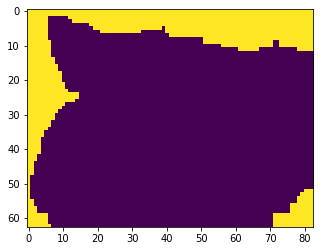

[99.]


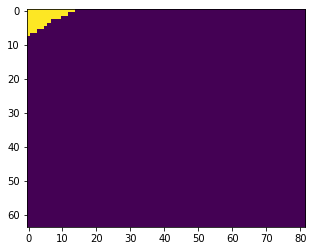

[0.]


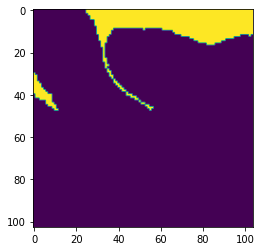

[99.]


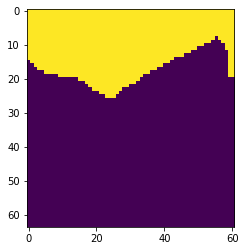

[0.]


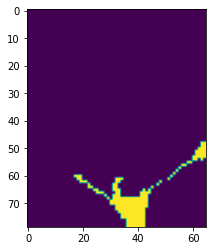

[0.]


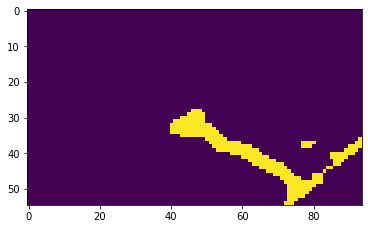

[0.]


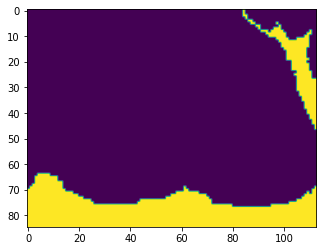

[0.]


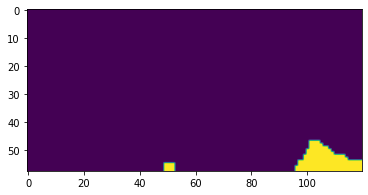

[0.]


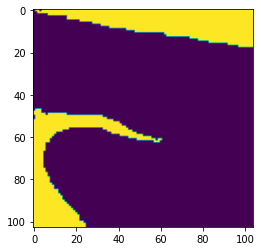

[0.]


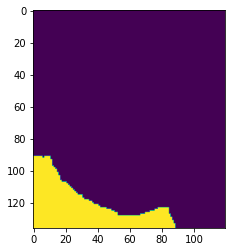

[0.]


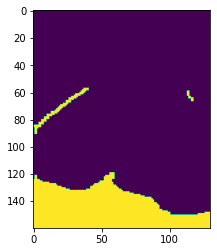

In [29]:
print(len(MALDI_results['background_data'][0]))
print(len(MALDI_results['tissue_data'][0]))
samples = np.loadtxt(results_folder + 'samples.csv', dtype = str)#pattern: 'brain{sample}re_{section}_{ROI}


In [3]:
M.print_metadata()

{'file_description': {'type': 'fileContent',
                      'MS1 spectrum': True,
                      'profile spectrum': True,
                      'universally unique identifier': '{25E35984-2347-4920-A79F-DE910FCF0A22}',
                      'ibd SHA-1': 'F44F56ACA54C1C4509A79B52C847BBF8713C81E2',
                      'processed': True,
                      'source_files': {'sf1': {'type': 'sourceFile',
                                               'id': 'sf1',
                                               'name': '20210614_JW_#2_Schnitt49_V1.raw',
                                               'location': 'C:\\Xcalibur\\data\\2021\\2021_Jan\\20210614_JW_#2_Schnitt49_V1\\',
                                               'Thermo RAW format': True,
                                               'Thermo nativeID format': True,
                                               'SHA-1': ''}},
                      'contacts': [{'type': 'contact',
                             

### Load raw data

In [3]:
M_raw = rawMALDI(M.filename, M.resolution, M.Range, M.n_processes)
mzs = np.array([551.503, 605.548, 627.532, 697.478])#, 756.551, 768.588, 776.593, 781.622 ,784.583 ,790.608 ,810.598, 823.666, 832.664, 835.66, 835.669, 849.682, 863.698, 920.708])


### show TIC, single mass, single mass after normalization and center of mass images

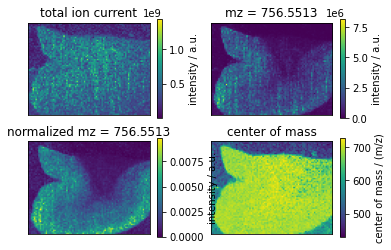

In [4]:
fig, axs = plt.subplots(2,2)

img = M_raw.get_2D(M_raw.sumpicture())
im = axs.flat[0].imshow(img)
axs.flat[0].set_xticks([])
axs.flat[0].set_yticks([])
axs.flat[0].set_title('total ion current')
fig.colorbar(im, ax = axs.flat[0], label = 'intensity / a.u.')

mz = mzs[0]
#753.588017481237#756.5513
img = M_raw.get_2D(M_raw.massvec(mz))
im = axs.flat[1].imshow(img)
axs.flat[1].set_xticks([])
axs.flat[1].set_yticks([])
axs.flat[1].set_title('mz = 756.5513')
fig.colorbar(im, ax = axs.flat[1], label = 'intensity / a.u.')

M_raw.normalize()    #data is changed in place, multiple execution of code block will alter the first two plots, if the prior code block is not re-executed as well
img = M_raw.get_2D(M_raw.massvec(mz))
im = axs.flat[2].imshow(img)
axs.flat[2].set_xticks([])
axs.flat[2].set_yticks([])
axs.flat[2].set_title('normalized mz = 756.5513')
fig.colorbar(im, ax = axs.flat[2], label = 'intensity / a.u.')

img = M_raw.get_2D(M_raw.center_of_mass())
im = axs.flat[3].imshow(img)
axs.flat[3].set_xticks([])
axs.flat[3].set_yticks([])
axs.flat[3].set_title('center of mass')
fig.colorbar(im, ax = axs.flat[3], label = 'center of mass / (m/z)')
plt.show()